In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import countplot, lineplot, barplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
import math
from itertools import chain
from rgf.sklearn import RGFClassifier
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import kurtosis

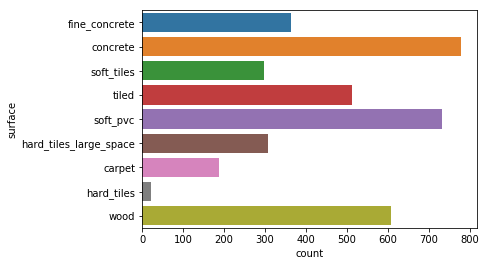

In [2]:
def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = np.sqrt(np.square(actual['angular_velocity_X']) + 
                                        np.square(actual['angular_velocity_Y']) + 
                                        np.square(actual['angular_velocity_Z']))
    actual['total_linear_acceleration'] = np.sqrt(np.square(actual['linear_acceleration_X']) + 
                                            np.square(actual['linear_acceleration_Y']) + 
                                            np.square(actual['linear_acceleration_Z']))
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    def f3(x):
        return np.mean(np.diff(np.abs(np.diff(np.abs(np.diff(x))))))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order. Higher orders reduce accuracy.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new


X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
SS = pd.read_csv('sample_submission.csv')

X_train.head()
countplot(y = 'surface', data = y_train)
plt.show()

In [3]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''
def scorer(estimator, X, y):
    return balanced_cv(confusion_matrix(estimator.predict(X.iloc[test_index]), y['surface'].iloc[test_index]))
'''
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))


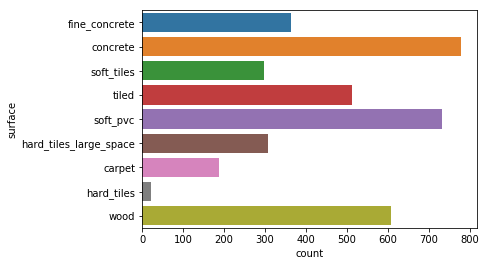

In [4]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
SS = pd.read_csv('sample_submission.csv')

X_train.head()
countplot(y = 'surface', data = y_train)
plt.show()

In [5]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

X_train = fe(X_train)
X_test = fe(X_test)

# Imputation   
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)

X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,0.011795,2.055021,2.049684,2.061288,0.003219,1.005661,0.000097,-8.169853e-07,2.061288,2.049684
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,0.014645,-0.635656,-0.638340,-0.634294,0.000931,0.993661,0.000071,9.790398e-08,0.638340,0.634294
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,0.009358,-0.894147,-0.915040,-0.867983,0.013836,0.948575,0.000371,4.805791e-07,0.915040,0.867983


____________________ 0 ____________________
train_score  0.9825886990801577
balanced cv score 0.8058878509918065
____________________ 1 ____________________
train_score  0.9848932676518883
balanced cv score 0.7875441258983116
____________________ 2 ____________________
train_score  0.9822834645669292
balanced cv score 0.8270767185345513
____________________ 3 ____________________
train_score  0.9836065573770492
balanced cv score 0.8436232523986973
____________________ 4 ____________________
train_score  0.9832951195545365
balanced cv score 0.8435618039764202
________________________________________
Avg Balanced Accuracy 0.8215387503599573

 ____________CV CONF MATS____________


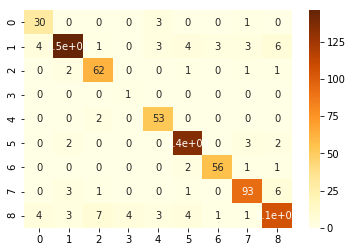

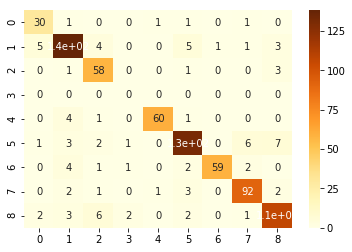

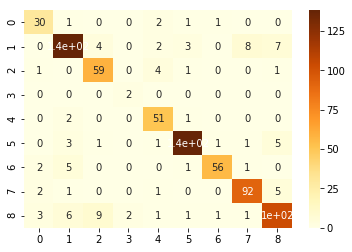

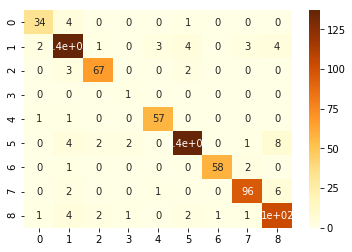

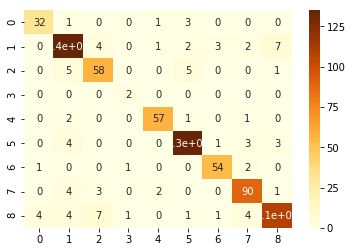

In [12]:
split_count = 5
# folds = GroupShuffleSplit(n_splits=split_count, random_state=1337)
folds = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337)
sub_preds = np.zeros((X_test.shape[0], 9))
score_sum = 0
balanced_cv_sum = 0
'''
clf = LGBMClassifier(colsample_bytree=0.03581900508076567, learning_rate=0.09308743154192588, 
                     max_bin=471, max_depth=-1, min_child_samples=50, min_child_weight=10, 
                     n_estimators=51, num_leaves=82, reg_alpha=2.0036361362515476e-07, reg_lambda=0.2069846982564452,
                     scale_pos_weight=9.05248363351552, subsample=0.9056112605172989, subsample_for_bin=368683, 
                     subsample_freq=9)
'''
# clf = XGBClassifier(tree_method = 'gpu_hist')
'''
clf = RandomForestClassifier(max_depth=77, min_impurity_decrease=8.435373293206687e-08, 
                             min_samples_leaf=10, min_samples_split=4, min_weight_fraction_leaf=0.0, 
                             n_estimators=170, random_state=1337)
'''
# clf = RandomForestClassifier(max_depth=65, min_impurity_decrease=9.756650941323682e-08, min_samples_leaf=1, min_samples_split=3,
#                             min_weight_fraction_leaf=0.0, n_estimators=300, class_weight='balanced_subsample')

# clf = RandomForestClassifier(n_estimators = 200, n_jobs =- 1)

clf = RGFClassifier(verbose=False)

# Training and cross validation.
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'])):

    print('_'*20, i, '_'*20)
    clf.fit(X_train.iloc[train_index], y_train['surface'][train_index])
    score_sum += clf.score(X_train.iloc[test_index], y_train['surface'][test_index])
    print('train_score ', clf.score(X_train.iloc[train_index], y_train['surface'][train_index]))
    # print('cv_score ', clf.score(X_train.iloc[test_index], y_train['surface'][test_index]))
    plt.figure()
    cm = confusion_matrix(clf.predict(X_train.iloc[test_index]), y_train['surface'].iloc[test_index])
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    # print(cm)
    
    '''
    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    '''
    

print('_'*40)
mean_cv_acc = score_sum / (split_count)
mean_balanced_cv_acc = balanced_cv_sum / (split_count)
# print('Avg CV Accuracy', mean_cv_acc)
print('Avg Balanced Accuracy', mean_balanced_cv_acc)
clf.fit(X_train, y_train['surface'])
sub_preds = clf.predict_proba(X_test)
print("\n ____________CV CONF MATS____________")
SS['surface'] = le.inverse_transform(sub_preds.argmax(axis=1))
SS.to_csv('rf.csv', index=False)

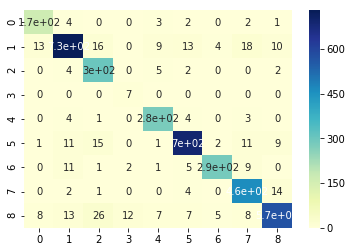

In [7]:
cm = confusion_matrix(clf.predict(X_train), y_train['surface'])
sns.heatmap(cm, annot=True, cmap="YlGnBu")

In [71]:
print(y_train['surface'].value_counts())

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64


In [72]:
print(le.inverse_transform(y_train['surface'].unique()))
print(y_train['surface'].unique())

['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']
[2 1 6 7 5 4 0 3 8]


In [73]:
print("Training group id occurances and conf mat.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['group_id'].iloc[test_index]).value_counts())

Training group id occurances and conf mat.
72    18
45    18
47    18
53    18
22    18
65    17
44    17
71    17
54    16
38    16
25    15
34    15
60    15
19    15
48    15
16    14
57    14
35    14
41    13
69    13
6     13
64    13
23    13
12    13
20    13
15    13
14    12
29    12
66    12
42    12
      ..
59    11
51    11
10    10
68    10
31    10
11    10
13     9
8      9
61     9
4      9
70     9
46     9
55     9
21     8
7      8
3      8
33     8
9      8
36     7
63     6
56     6
28     6
27     5
17     4
67     3
58     2
5      2
2      2
37     2
50     1
Name: group_id, Length: 70, dtype: int64
55    20
45    19
3     18
54    17
42    17
35    17
32    17
59    16
38    16
6     16
69    15
4     15
51    15
68    15
48    15
20    14
47    14
41    14
14    14
53    14
33    14
34    13
44    13
46    13
62    13
61    13
15    13
7     13
49    12
66    12
      ..
11    10
72    10
70    10
64    10
60    10
26     9
28     9
31     9
71     9
65     

In [74]:
print("\n\nCV group id counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['group_id'].iloc[test_index]).value_counts())
    
print("\n\nTraining label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['surface'].iloc[train_index]).value_counts())
    
print("\n\nCV label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['surface'].iloc[test_index]).value_counts())



CV group id counts.
72    18
45    18
47    18
53    18
22    18
65    17
44    17
71    17
54    16
38    16
25    15
34    15
60    15
19    15
48    15
16    14
57    14
35    14
41    13
69    13
6     13
64    13
23    13
12    13
20    13
15    13
14    12
29    12
66    12
42    12
      ..
59    11
51    11
10    10
68    10
31    10
11    10
13     9
8      9
61     9
4      9
70     9
46     9
55     9
21     8
7      8
3      8
33     8
9      8
36     7
63     6
56     6
28     6
27     5
17     4
67     3
58     2
5      2
2      2
37     2
50     1
Name: group_id, Length: 70, dtype: int64
55    20
45    19
3     18
54    17
42    17
35    17
32    17
59    16
38    16
6     16
69    15
4     15
51    15
68    15
48    15
20    14
47    14
41    14
14    14
53    14
33    14
34    13
44    13
46    13
62    13
61    13
15    13
7     13
49    12
66    12
      ..
11    10
72    10
70    10
64    10
60    10
26     9
28     9
31     9
71     9
65     9
8      9
10     9
1

In [75]:
'''
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        criterion='gini',
        verbose=1,
        max_features='auto',
        max_leaf_nodes=None,
        random_state = 1337
        
    ),
    search_spaces = { 
        'max_depth': (1, 200),
        'n_estimators': (20, 300),
        'min_samples_split': (2,20),
        'min_samples_leaf': (1,10),
        'min_weight_fraction_leaf': (0.0,0.5),
        'min_impurity_decrease': (0,1E-7),
        
        
    },    
    cv = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337),
    n_jobs = -1,
    n_iter = 40,   
    verbose = 1
)

# Fit the model
result = bayes_cv_tuner.fit(X_train, y_train['surface'], groups=y_train['group_id'], callback=status_print)
'''

"\n# Classifier\nbayes_cv_tuner = BayesSearchCV(\n    estimator = RandomForestClassifier(\n        criterion='gini',\n        verbose=1,\n        max_features='auto',\n        max_leaf_nodes=None,\n        random_state = 1337\n        \n    ),\n    search_spaces = { \n        'max_depth': (1, 200),\n        'n_estimators': (20, 300),\n        'min_samples_split': (2,20),\n        'min_samples_leaf': (1,10),\n        'min_weight_fraction_leaf': (0.0,0.5),\n        'min_impurity_decrease': (0,1E-7),\n        \n        \n    },    \n    cv = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337),\n    n_jobs = -1,\n    n_iter = 40,   \n    verbose = 1\n)\n\n# Fit the model\nresult = bayes_cv_tuner.fit(X_train, y_train['surface'], groups=y_train['group_id'], callback=status_print)\n"